## Análisis Comercial de clientes

In [2]:
# 1. Librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import openpyxl
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import plotly.express as px
from io import StringIO

# Configuración visual
"""pd.set_option('display.max_columns', None)
sns.set(style="whitegrid", palette="muted", font_scale=1.1)"""


'pd.set_option(\'display.max_columns\', None)\nsns.set(style="whitegrid", palette="muted", font_scale=1.1)'

In [4]:
# Rango de Fechas

# El uso de la central "Anura" arranca el 26-05-2021
# El comienzo de Zoho Desk es 

fecha_inicio = "2023-01-01 00:01"
fecha_fin = "2024-12-31 23:59"

## Carga de Datos

In [28]:
# Cargar desde CSV (puedes adaptarlo para leer desde BD o Excel)
# El CSV debería tener columnas como: Cliente, Licencias, Productos, Tickets, Llamadas, Antiguedad_Anios

"""

df = pd.read_csv("clientes.csv")

print("Vista previa de datos:")
display(df.head())
print("\nInformación general:")
print(df.info())

"""



'\n\ndf = pd.read_csv("clientes.csv")\n\nprint("Vista previa de datos:")\ndisplay(df.head())\nprint("\nInformación general:")\nprint(df.info())\n\n'

In [3]:
# LLAMADAS desde Anura

def generarDS_Anura(start_date, end_date):
    """
    Genera un request a la API de Anura para obtener un DataSet que luego procesaremos.
    Parámetros: 
        start_date: fecha inicio
        end_date: fecha final
    Retorno:
        df : DataFrame que sería la sábana de datos en el rango de fecha establecido.
    """
    
    # Datos de autenticación y solicitud para obtener el archivo CSV
    CLIENT_ID = "sc_5187_etsol"
    CLIENT_PASSWORD = "f413f20c-e550-46b2-a992-3e6682c66176"

    url_token = "https://sso.anura.com.ar/auth/realms/anura/protocol/openid-connect/token"
    data = {
        "grant_type": "client_credentials",
        "scope": "offline_access"
    }

    response = requests.post(url_token, data=data, auth=(CLIENT_ID, CLIENT_PASSWORD))
    refresh_token = response.json()['refresh_token']

    data = {
        "grant_type": "refresh_token",
        "refresh_token": refresh_token,
        "client_id": CLIENT_ID
    }

    response = requests.post(url_token, data=data, auth=(CLIENT_ID, CLIENT_PASSWORD))
    access_token = response.json()['access_token']

    url_gcapi = "https://api.anura.com.ar/GCAPI/JSON-RPC"
    headers = {
        "Authorization": f"Bearer {access_token}"
    }
    payload = {
        "id": 6,
        "method": "AdminService.getDownloadToken",
        "params": []
    }

    response = requests.post(url_gcapi, headers=headers, json=payload)
    token_gcapi = response.json()['result']

    # se define fecha antes de entrar a este segmento de código.
    """ start_date = "2024-05-04 00:00"
    end_date = "2024-05-04 23:59" """

    url_export_cdrs = f"https://api.anura.com.ar/GCAPI/Download/ExportCdrs?Authorization={token_gcapi}&startDate={start_date}&endDate={end_date}&filter=&extraInfo=true&accountId="
    response = requests.get(url_export_cdrs)

    # Leer los datos en un DataFrame
    df = pd.read_csv(StringIO(response.content.decode('unicode_escape'))) # Utilizo la misma codificación que uso en el principal "telefonia.ipynb"

    # Verificamos que haya datos para procesar
    if df.shape[0] == 0:
        print("Dataset vacío .......")
    
    return df # Retorno con el df para depurarlo y comenzar a trabajarlo.

In [5]:
ds_llamadas = generarDS_Anura(fecha_inicio, fecha_fin)
display(ds_llamadas)

,Fecha,DirecciÃ³n,Nro. Origen,Origen,Nro. Destino,Destino,Estado,DuraciÃ³n total,DuraciÃ³n conversaciÃ³n,Tiempo espera,...,Cola nombre,Cola estado,Cola duraciÃ³n total,Cola duraciÃ³n conversaciÃ³n,Cola tiempo espera,Cola agente,Cola terminal agente,Cuenta contestÃ³,Terminal contestÃ³,Departamento
0,2024-07-01 07:45:56.378,IN,3415962322,Argentina/ROSARIO - MOVIL,01170780972,Preatendedor,ANSWER,25,25,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Mesa de Soporte
1,2024-07-01 07:46:20.704,OUT,3415962322,NaN,800,Soporte2,ANSWER,11,11,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Mesa de Soporte
2,2024-07-01 07:46:20.734,IN,3415962322,Argentina/ROSARIO - MOVIL,800,Soporte2,ANSWER,11,11,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Mesa de Soporte
3,2024-07-01 07:46:39.181,IN,3415962322,Argentina/ROSARIO - MOVIL,01170780972,Preatendedor,ANSWER,12,12,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Mesa de Soporte
4,2024-07-01 07:46:51.222,OUT,3415962322,NaN,800,Soporte2,ANSWER,11,11,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Mesa de Soporte
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36483,2024-12-31 13:22:20.498,IN,1132022600,Argentina/AMBA - MOVIL,800,Soporte2,ANSWER,30,30,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Mesa de Soporte
36484,2024-12-31 13:22:49.92,OUT,1132022600,NaN,800,Soporte2,ANSWER,52,52,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Mesa de Soporte
36485,2024-12-31 13:22:49.953,IN,1132022600,Argentina/AMBA - MOVIL,800,Soporte2,ANSWER,40,40,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Mesa de Soporte
36486,2024-12-31 13:23:29.902,OUT,1132022600,NaN,800,Soporte2,ANSWER,12,12,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Mesa de Soporte


# Tickets
    - Tickets desde 01-01-2021 al 31-08-2025 

In [22]:
# Tomamos los datos del archivo *.csv almacenado de manera local 
# Este archivo *.csv tiene todos los tickets de Clientes
df_crudo_tickets = pd.read_csv('ds/Cantidad de Ticket por Rango Fecha_01012021_31082025.csv', sep=',' , encoding='utf-8')

# ---------------------------- Análisis Exploratorio de Datos -------------------------------------------------------------------------------
new_header = df_crudo_tickets.iloc[3] # Tomar la fila 3 como "cabecera".

# Eliminar las primeras 4 filas y luego la fila que acabamos de usar como encabezado para que los datos comiencen desde la fila 4
df_tickets = df_crudo_tickets[4:] # Selecciona todas las filas desde el índice 4 en adelante

# Asignar los nuevos nombres de columna
df_tickets.columns = new_header
df_tickets = df_tickets.reset_index(drop=True) # Reniciamos el índice

# Especifica el formato de acuerdo a tu caso
formato = '%d %b %Y %I:%M %p'  # dd: día, MMM: mes abreviado, yyyy: año, HH: horas en formato 12h, MM: minutos, AM/PM
# Separamos fecha y hora en campos diferentes
df_tickets['Fecha_creacion'] = pd.to_datetime(df_tickets['Hora de creación (Ticket)'], format=formato).dt.date
df_tickets['Hora_creacion'] = pd.to_datetime(df_tickets['Hora de creación (Ticket)'], format=formato).dt.time

#Eliminamos la columna "Hora de creación (Ticket)"
df_tickets = df_tickets.drop(columns=['Hora de creación (Ticket)'])

# Encontramos casos de tickets que NO tienen cargado el cliente. Se usan para esos casos los valores "-" y "--" vamos a reemplazarlos
df_tickets["Nombre de Cuenta"] = df_tickets["Nombre de Cuenta"].replace(["-", "--"], "s/r")



C:\Users\USUARIO\AppData\Local\Temp\ipykernel_12032\3469558274.py:3: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_crudo_tickets = pd.read_csv('ds/Cantidad de Ticket por Rango Fecha_01012021_31082025.csv', sep=',' , encoding='utf-8')


In [23]:
df_tickets.head(-2)

3,ID de Ticket,Nombre de Cuenta,Asunto,Descripción del error,Ticket Descripción,Estado (Ticket),Fecha de cierre,Canal,Clasificaciones,Motivo de la urgencia,Propietario de Ticket,Módulo,Fecha_creacion,Hora_creacion
0,1000,HODASAN,Problema con CAE,-,NaN,Cerrado,-,Chat,Consulta,-,Sergio de los Santos,-,2021-03-26,13:07:00
1,10001,ANGACO MATERIALES,CONSULTA VISUALIZACION PRODUCTOS PENDIENTES DE...,-,NaN,No aplica,-,Chat,Consulta,-,Juan Pablo Cabrera,-,2021-08-03,15:33:00
2,10002,ARCO MAQUINARIAS,Buenas tardes,-,NaN,No aplica,-,Chat,Consulta,-,Juan Pablo Cabrera,-,2021-08-03,15:34:00
3,10003,ANDERSEN MATERIALES,RE: PREGUNTAS DEL SISTEMA NUEVO,-,NaN,Cerrado,-,Email,Consulta,-,Eliana Barreto,-,2021-08-03,15:43:00
4,10004,FUGAS,Script de bloqueo,-,"Buen dia, actualmente el punto de venta 5 y 10...",No aplica,-,Web,Consulta,-,Juan Pablo Cabrera,-,2021-08-03,15:46:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102549,104103,Lampe,Chat sábados,-,Chat sábados,Cerrado,30 Aug 2025,Chat,Consulta,-,Leila Bonacina,Sábado,2025-08-30,09:39:00
102550,104104,Lampe,Solicita archivos xls par aimportar los codigo...,-,Solicita archivos xls par a importar los códig...,Cerrado,01 Sep 2025,Web,Consulta,-,Leila Bonacina,PalJet Import,2025-08-30,09:41:00
102551,104105,LOGBELTS SRL,"Error al solicitar cae ""el numero de comproba...",-,Error al solicitar cae el numero de comprobant...,Cerrado,30 Aug 2025,Phone,Consulta,-,Leila Bonacina,Factura electrónica,2025-08-30,09:50:00
102552,104106,BOURLOT,Consulta por anulación de remito,-,NaN,Cerrado,30 Aug 2025,Phone,Consulta,-,Lautaro Bustos,CPR Ventas,2025-08-30,09:58:00


- Algunas pruebas

In [24]:
# Asegúrate de que 'Fecha_creacion' es de tipo datetime
df_tickets['Fecha_creacion'] = pd.to_datetime(df_tickets['Fecha_creacion'])
# Filtrar los tickets de julio de 2025
tickets_julio_2025 = df_tickets.loc[(df_tickets['Fecha_creacion'].dt.month == 7) & 
                                      (df_tickets['Fecha_creacion'].dt.year == 2025)]
# Contar la cantidad de tickets
cantidad_tickets = tickets_julio_2025.shape[0]  # O puedes usar len(tickets_julio_2025)
print(f'Cantidad de tickets con fecha de creación en julio de 2025: {cantidad_tickets}')

Cantidad de tickets con fecha de creación en julio de 2025: 2160


In [25]:
# Asegúrate de que 'Fecha_creacion' es de tipo datetime
df_tickets['Fecha_creacion'] = pd.to_datetime(df_tickets['Fecha_creacion'])
# Filtrar los tickets de julio de 2025
tickets_julio_2025 = df_tickets.loc[(df_tickets['Fecha_creacion'].dt.month == 7) & 
                                      (df_tickets['Fecha_creacion'].dt.year == 2025)]
# Obtener todas las clasificaciones únicas
clasificaciones_unicas = tickets_julio_2025['Clasificaciones'].unique()
# Convertir a una lista si lo deseas
clasificaciones_lista = clasificaciones_unicas.tolist()
print("Clasificaciones de tickets en julio de 2025:")
print(clasificaciones_lista)

Clasificaciones de tickets en julio de 2025:
['Mejora', 'Consulta', 'Incidente', 'Requerimiento', 'Actualización', 'Adquisición Licencia/Módulos', 'Instalación', 'Baja Licencia/Modulo', 'Capacitación', '-', 'Infraestructura', 'PalJet ERP', 'Capacitación presencial']


# CRM
- Licencias
- Productos

In [13]:
# Análisis de Productos - Módulos - Licencias
df_crudo_CRM = pd.read_csv('ds/Clientes-Modulos-Productos-Licencias.csv', sep=',' , encoding='utf-8')

#----- Análisis Exploratorio de Datos -------------------
new_header_CRM = df_crudo_CRM.iloc[3] # Tomar la fila 3 como "cabecera".

# Eliminar las primeras 4 filas y luego la fila que acabamos de usar como encabezado para que los datos comiencen desde la fila 4
df_CRM = df_crudo_CRM[4:] # Selecciona todas las filas desde el índice 4 en adelante


In [14]:
df_CRM.head()

,Nombre de Cuenta,Tipo de Cuenta,Nombre de Modulo Activo,Producto,Cantidad de PC,Cantidad de teléfonos Mobile,Cantidad de Usuarios,Calificación,Fecha de Venta,Fecha de Alta,Fecha de baja Paljet,Fecha de Inicio PalJetERP,Estado
4,ARCOIRIS PINTURERIA,Cliente,ARCOIRIS PINTURERIA - Logística,Módulo Logística,20,NaN,23.0,Activo,19/09/2024,16/09/2024,NaN,NaN,Activo
5,ARCOIRIS PINTURERIA,Cliente,ARCOIRIS PINTURERIA - Contabilidad,Módulo Contabilidad,20,NaN,23.0,Activo,19/09/2024,16/09/2024,NaN,NaN,Activo
6,ARCOIRIS PINTURERIA,Cliente,ARCOIRIS PINTURERIA - CUIT adicional,CUIT adicional,20,NaN,23.0,Activo,19/09/2024,16/09/2024,NaN,NaN,Activo
7,ARCOIRIS PINTURERIA,Cliente,ARCOIRIS PINTURERIA - Factura de Crédito Elect...,Módulo Factura de crédito electrónica,20,NaN,23.0,Activo,19/09/2024,16/09/2024,NaN,NaN,Activo
8,ARCOIRIS PINTURERIA,Cliente,ARCOIRIS PINTURERIA - PalJet ERP,PalJet ERP estándar - Licencia servidor (backend),20,NaN,23.0,Activo,19/09/2024,16/09/2024,NaN,NaN,Inactivo


In [8]:
ranking_producto=df_CRM.groupby("Nombre de Cuenta")["Producto"].count().reset_index().sort_values(by="Producto", ascending=False)
ranking_producto.to_excel('ranking_producto.xlsx', index=False)


In [16]:
df_CRM.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1299 entries, 4 to 1302
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Nombre de Cuenta              1299 non-null   object 
 1   Tipo de Cuenta                1299 non-null   object 
 2   Nombre de Modulo Activo       1299 non-null   object 
 3   Producto                      1290 non-null   object 
 4   Cantidad de PC                1299 non-null   int64  
 5   Cantidad de teléfonos Mobile  234 non-null    float64
 6   Cantidad de Usuarios          67 non-null     float64
 7   Calificación                  1299 non-null   object 
 8   Fecha de  Venta               1293 non-null   object 
 9   Fecha de Alta                 1286 non-null   object 
 10  Fecha de baja Paljet          83 non-null     object 
 11  Fecha de Inicio PalJetERP     1230 non-null   object 
 12  Estado                        508 non-null    object 
dtypes: 

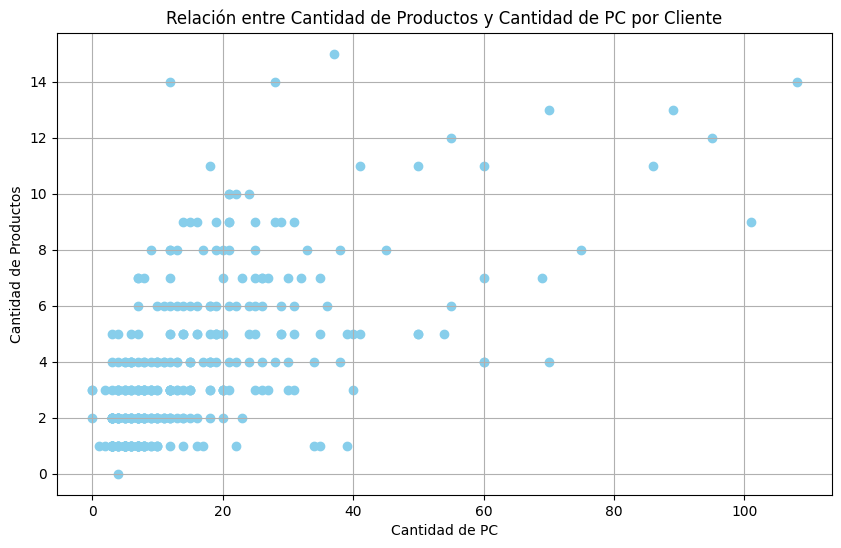

                       Cantidad de PC  Cantidad de Productos
Cantidad de PC               1.000000               0.622388
Cantidad de Productos        0.622388               1.000000


In [21]:
# Contar la cantidad de productos por cliente
productos_por_cliente = df_CRM.groupby('Nombre de Cuenta')['Producto'].nunique().reset_index()
productos_por_cliente.columns = ['Nombre de Cuenta', 'Cantidad de Productos']
# Obtener la cantidad única de PCs por cliente (suponiendo que hay un valor único por cliente)
pc_por_cliente = df_CRM.groupby('Nombre de Cuenta')['Cantidad de PC'].first().reset_index()
# Combinar ambos DataFrames
analisis = pd.merge(productos_por_cliente, pc_por_cliente, on='Nombre de Cuenta')
# Visualizar la relación
plt.figure(figsize=(10, 6))
plt.scatter(analisis['Cantidad de PC'], analisis['Cantidad de Productos'],  color='skyblue')
plt.xlabel('Cantidad de PC')
plt.ylabel('Cantidad de Productos')
plt.title('Relación entre Cantidad de Productos y Cantidad de PC por Cliente')
plt.grid()
plt.show()
# Calcular la correlación
correlation = analisis[['Cantidad de PC','Cantidad de Productos']].corr()
print(correlation)

## 3. Limpieza y preparación de los datos


In [ ]:
# Eliminar duplicados
df = df.drop_duplicates()

# Manejo de valores nulos
df = df.fillna(0)

# Crear métricas derivadas
df["Solicitudes_Total"] = df["Tickets"] + df["Llamadas"]
df["Solicitudes_por_Licencia"] = df["Solicitudes_Total"] / df["Licencias"].replace(0, np.nan)
df["Productos_por_Año"] = df["Productos"] / df["Antiguedad_Anios"].replace(0, np.nan)



In [ ]:
# =====================================================
# 4. ANÁLISIS EXPLORATORIO
# =====================================================

# Estadísticas descriptivas
print("\nEstadísticas generales:")
display(df.describe())

# Distribución de clientes por licencias
plt.figure(figsize=(8,5))
sns.histplot(df["Licencias"], bins=20, kde=True)
plt.title("Distribución de Licencias por Cliente")
plt.show()

# Relación Licencias vs. Tickets
plt.figure(figsize=(8,5))
sns.scatterplot(data=df, x="Licencias", y="Tickets")
plt.title("Licencias vs Tickets")
plt.show()

# Pareto: clientes que más solicitudes generan
df_pareto = df.sort_values("Solicitudes_Total", ascending=False)
df_pareto["% Acumulado"] = df_pareto["Solicitudes_Total"].cumsum() / df_pareto["Solicitudes_Total"].sum() * 100

fig = px.bar(df_pareto, x="Cliente", y="Solicitudes_Total", title="Pareto de Solicitudes por Cliente")
fig.add_scatter(x=df_pareto["Cliente"], y=df_pareto["% Acumulado"], mode="lines+markers", name="% Acumulado")
fig.show()



In [ ]:
# =====================================================
# 5. SEGMENTACIÓN DE CLIENTES (CLUSTERING)
# =====================================================

# Seleccionar variables para el modelo
vars_modelo = ["Licencias", "Productos", "Solicitudes_Total", "Antiguedad_Anios"]
X = df[vars_modelo]

# Escalado
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# K-Means
kmeans = KMeans(n_clusters=3, random_state=42)
df["Cluster"] = kmeans.fit_predict(X_scaled)

# Visualización de clusters
fig = px.scatter_3d(df, x="Licencias", y="Productos", z="Solicitudes_Total",
                    color="Cluster", hover_data=["Cliente"])
fig.show()



In [ ]:
# =====================================================
# 6. INSIGHTS INICIALES
# =====================================================
# Agrupar por cluster para ver promedios
insights = df.groupby("Cluster")[vars_modelo].mean()
print("\nPromedios por cluster:")
display(insights)

# Guardar resultados
df.to_csv("clientes_segmentados.csv", index=False)
print("\nArchivo 'clientes_segmentados.csv' generado.")